# Aircraft analysis

This is a small example in how to define a flying wing and calculate its aerodynamic coefficients using different methods.

The methods used in this analysis were implemented in [aerosandbox](https://github.com/peterdsharpe/AeroSandbox). You can find the comparison with external methods (from where most of this code was based on) [here](https://github.com/peterdsharpe/AeroSandbox/blob/master/tutorial/06%20-%20Aerodynamics/01%20-%20AeroSandbox%203D%20Aerodynamics%20Tools/01%20-%20Comparison%20and%20Validation%20-%20Flying%20Wing.ipynb)

We use the `WingSection` to create multiple wing sections with parameterized span, chord and sweep angle. We will follow the parameterization of the figure below in this example:

![alt text](../assets\WingSection_parameters_example.png "Title")


## Import libs



In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
from pathlib import Path
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

# Add duneglider to path
import sys
import os
notebook_dir = os.getcwd()
root_dir = os.path.dirname(notebook_dir)
sys.path.append(root_dir)

from duneglider.aircraft_model import WingSection

## Defining wing

Lets define a wing using `WingSection()` with some conditions and parameters:

This wing will have two sections:

- The wing should have a total span of $3 m$.
- We use a reference chord of $1 m$. This chord will be used in the root section.
- Wing sweep for the second section will be $40 º$. The first section will not have sweep.
- The root section should start at the origin.
- The second section should start at $20 %$ of the wing span.
- The trailing edge of the sections should follow a straight line.

Notice that we use the function `get_wing_tip_offset()` from section 1 to define the init_point of the section2. Also, notice the tip chord of the section 1 is the same as the init_chord of section 2.

In [2]:
wing_max_span = 3   
wing_ref_chord = 1
wing_sweep = np.radians(40)
wing_root_pnt = np.array([0, 0, 0])
wing_sec1_pct = 0.2

wing_sec1 = WingSection( span_tip=(wing_sec1_pct*wing_max_span)/2,
                         sweep = 0,
                         chord_tip = (1+wing_sec1_pct)*wing_ref_chord,
                         airfoil = asb.Airfoil("l1003"),
                         init_point = wing_root_pnt,
                         init_chord = wing_ref_chord)

wing_sec2 = WingSection( span_tip=(wing_max_span-wing_sec1_pct*wing_max_span)/2,
                         sweep = wing_sweep,
                         chord_tip = wing_ref_chord,
                         airfoil = asb.Airfoil("l1003"),
                         init_point = wing_sec1.get_wing_tip_offset(),
                         init_chord = wing_sec1.chord_tip)


## Defining an airplane

Now, using the previously defined wing section, we define an aircraft and plot it.

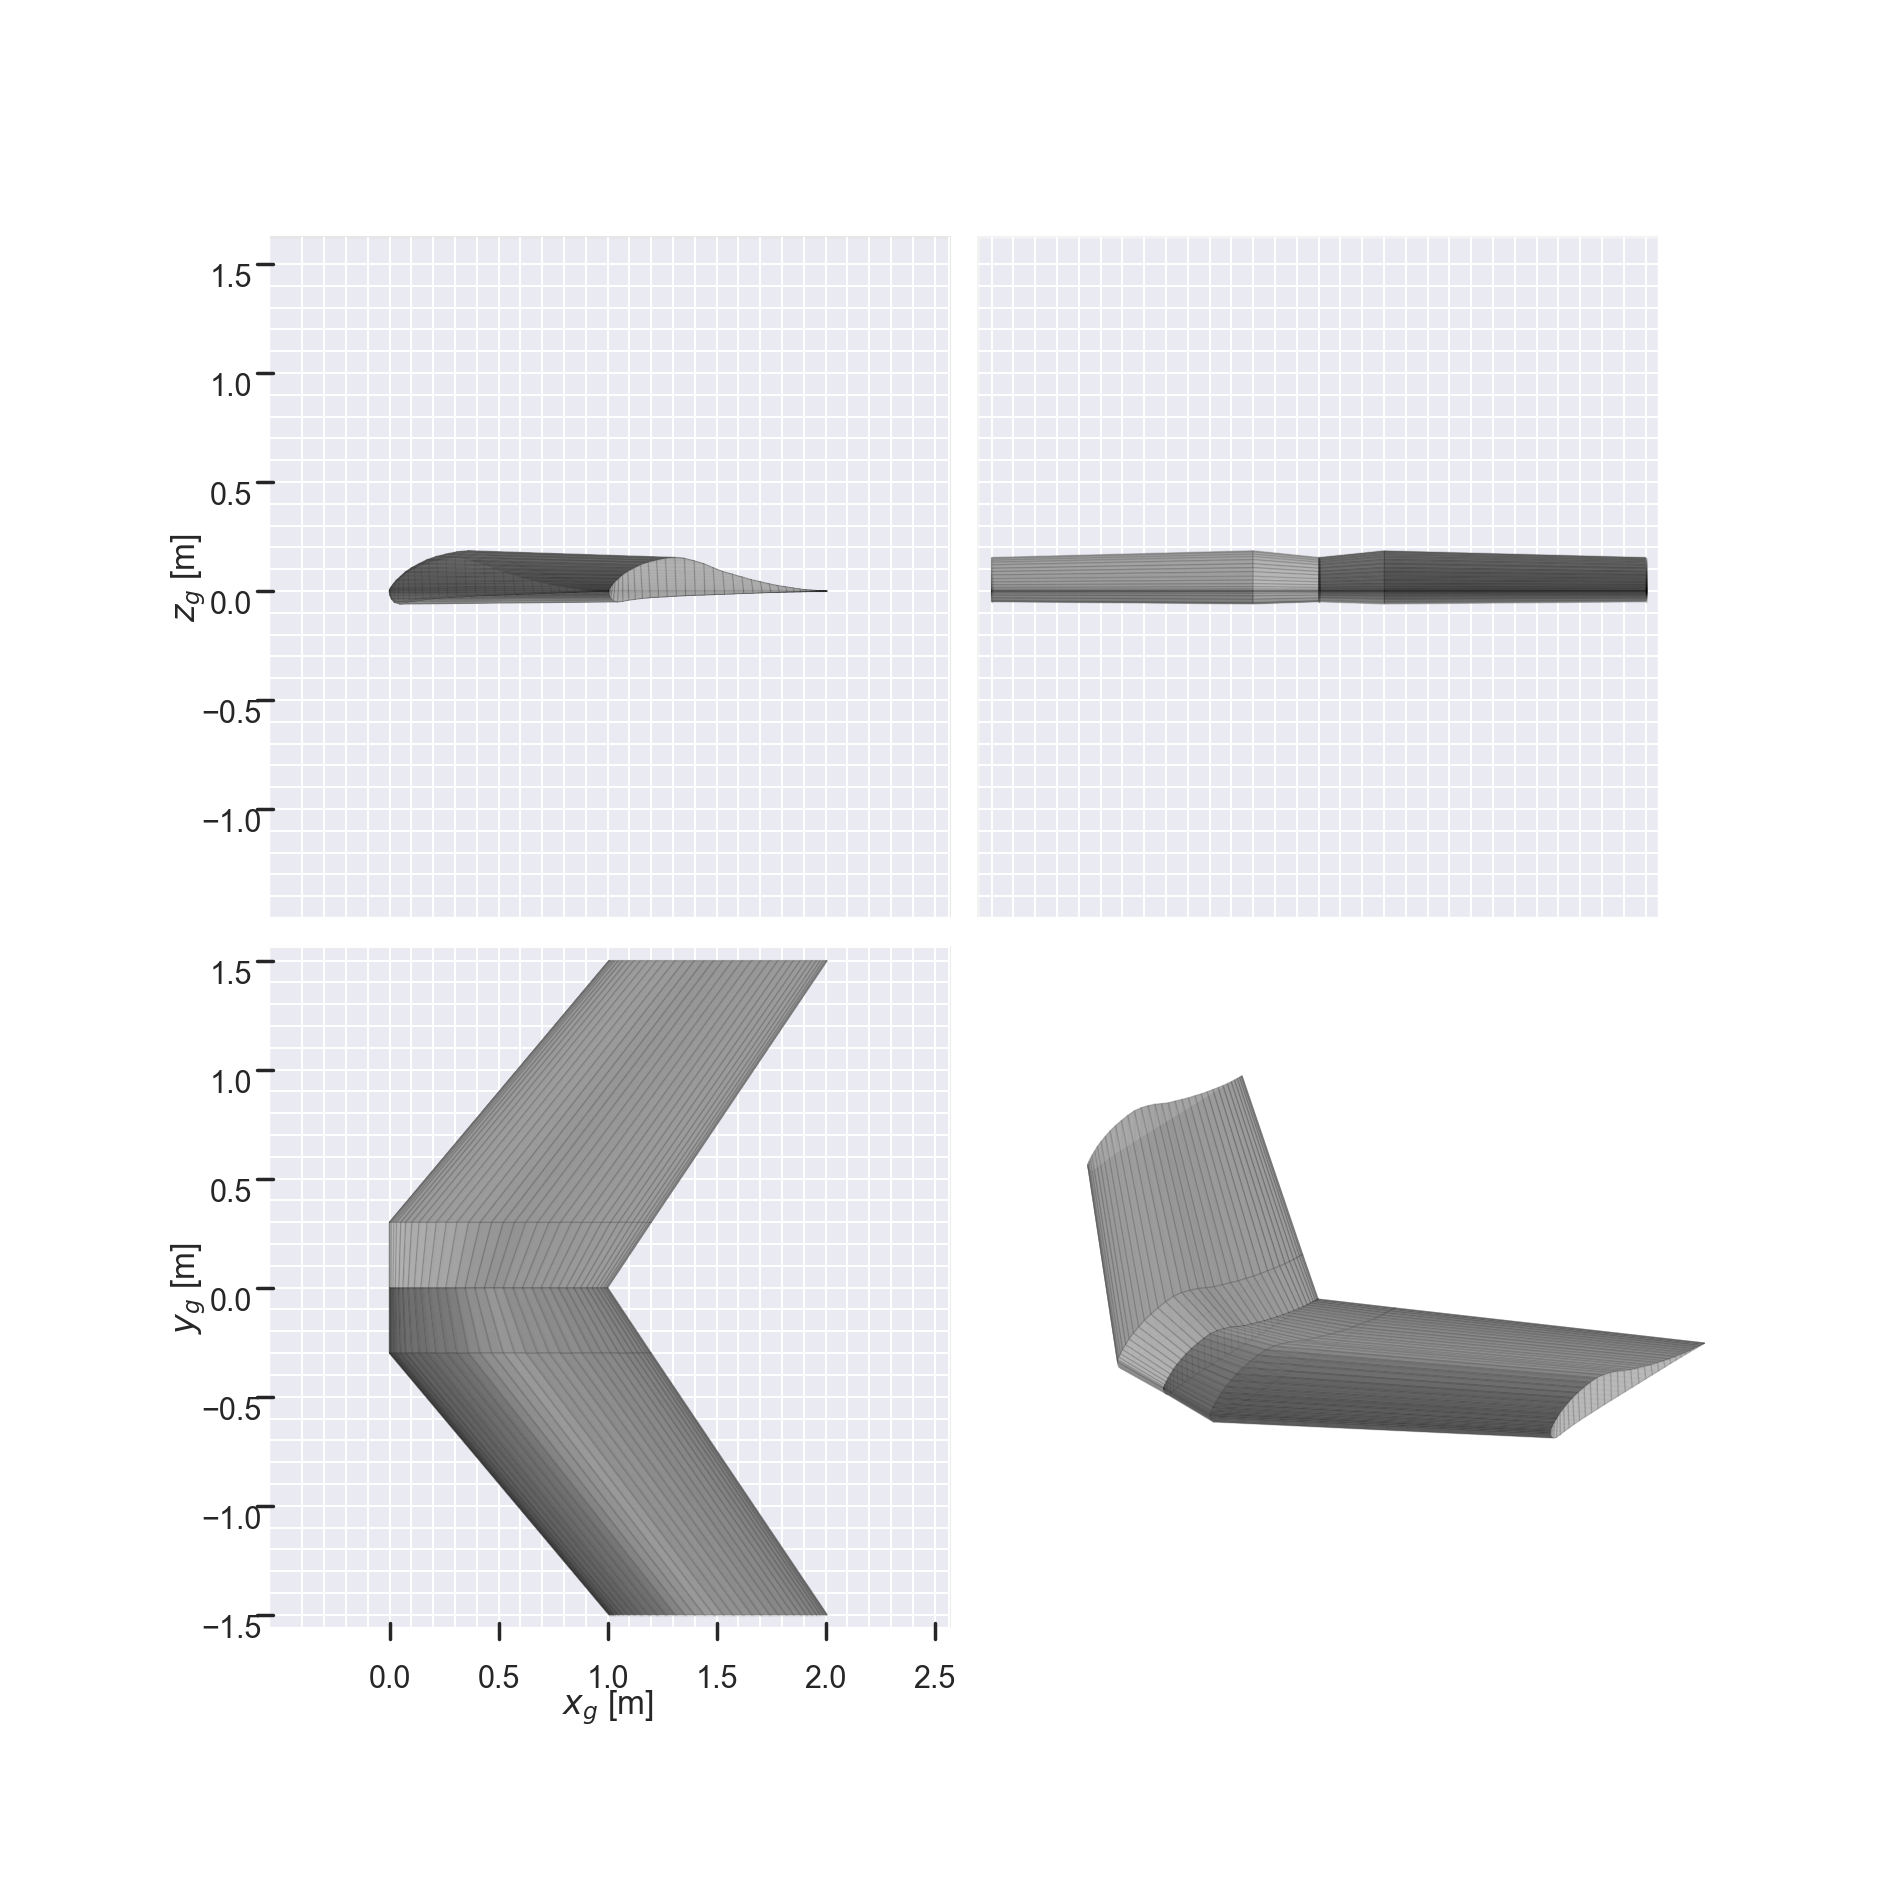

In [3]:
airplane = asb.Airplane(
    name="A random glider",
    xyz_ref=[0.66632031, 0, 0],  # CG location, in this case, lets assume it is located in aerodynamic center
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # Should this wing be mirrored across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # Root
                    xyz_le = wing_root_pnt,  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    chord = 1,
                    twist = 0.0,  # degrees
                    airfoil = asb.Airfoil("l1003")
                ),
                asb.WingXSec(
                    xyz_le = wing_sec1.get_wing_tip_offset(),
                    chord = wing_sec1.chord_tip,
                    twist = 0,
                    airfoil=asb.Airfoil("l1003")
                ),
                asb.WingXSec(
                    xyz_le = wing_sec2.get_wing_tip_offset(),
                    chord = wing_sec2.chord_tip,
                    twist = 0,
                    airfoil = asb.Airfoil("l1003")
                )
            ]
        )
    ]
)

ac = airplane.aerodynamic_center()
airplane.draw_three_view()

# Aerobuildup method

In [4]:
# AEROBUILDUP METHOD
op_point = asb.OperatingPoint(
    atmosphere=asb.Atmosphere(altitude=0),
    velocity=8,  # m/s
)

xyz_ref = ac
ab_op_point = op_point.copy()
ab_op_point.alpha = np.linspace(-12, 30, 50)

aerobuildup_aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=ab_op_point,
    xyz_ref=xyz_ref
).run()

aerobuildup_aero["alpha"] = ab_op_point.alpha

# VLM Method

In [5]:
# VLM METHOD
vlm_op_point = op_point.copy()
vlm_op_point.alpha = np.linspace(-12, 30, 13)

vlm_aeros = [
    asb.VortexLatticeMethod(
        airplane=airplane,
        op_point=op,
        xyz_ref=xyz_ref,
        spanwise_resolution=5
    ).run()
    for op in vlm_op_point
]

vlm_aero = {}

for k in vlm_aeros[0].keys():
    vlm_aero[k] = np.array([
        aero[k]
        for aero in vlm_aeros
    ])
vlm_aero["alpha"] = vlm_op_point.alpha

# Non-Linear LLT

In [6]:
# NON-LINEAR LLT
nlll_op_point = op_point.copy()
nlll_op_point.alpha = np.linspace(-10, 30, 11)

nlll_aeros = [
    asb.NonlinearLiftingLine(
        airplane=airplane,
        op_point=op,
        xyz_ref=xyz_ref,
    ).run()
    for op in nlll_op_point
]

nlll_aero = {}
for k in nlll_aeros[0].keys():
    nlll_aero[k] = np.array([
        aero[k]
        for aero in nlll_aeros
    ])
nlll_aero["alpha"] = nlll_op_point.alpha

# LLT

In [7]:
# LLT
ll_op_point = op_point.copy()
ll_op_point.alpha = np.linspace(-12, 30, 31)

ll_aeros = [
    asb.LiftingLine(
        airplane=airplane,
        op_point=op,
        xyz_ref=xyz_ref,
    ).run()
    for op in ll_op_point
]

ll_aero = {}
for k in ll_aeros[0].keys():
    ll_aero[k] = np.array([
        aero[k]
        for aero in ll_aeros
    ])
ll_aero["alpha"] = ll_op_point.alpha

# Plot comparisons

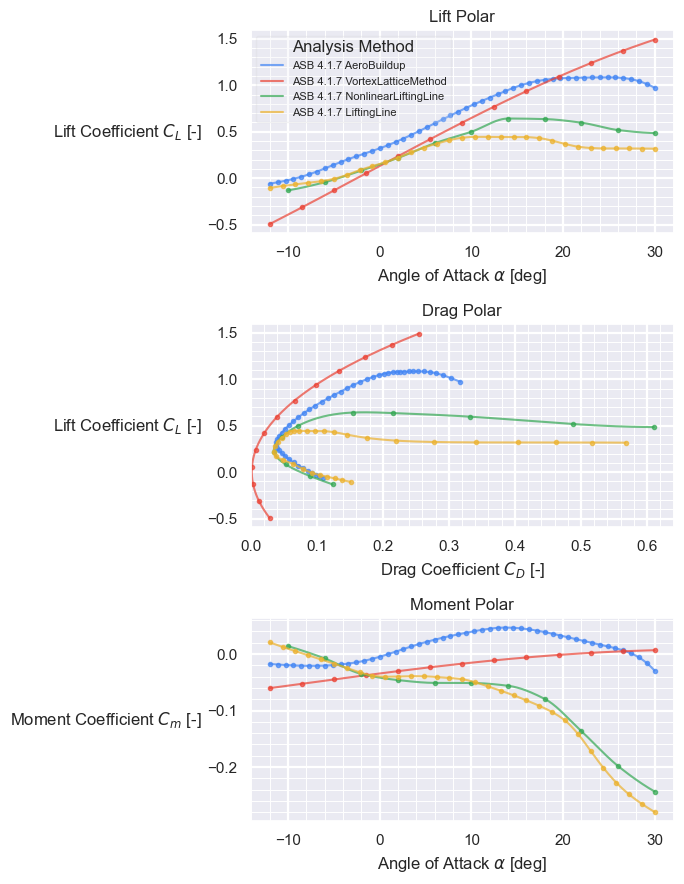

In [8]:
# PLOT:
fig, ax = plt.subplots(3, 1, figsize=(7, 9), dpi=100)

for name, aero in {
    f"ASB {asb.__version__} AeroBuildup"                       : aerobuildup_aero,
    f"ASB {asb.__version__} VortexLatticeMethod": vlm_aero,
    f"ASB {asb.__version__} NonlinearLiftingLine"            : nlll_aero,
    f"ASB {asb.__version__} LiftingLine"            : ll_aero,
}.items():
    plt.sca(ax[0])
    p.plot_smooth(
        aero["alpha"],
        aero["CL"],
        label=name,
        function_of="x",
        alpha=0.7,
    )

    plt.sca(ax[1])
    p.plot_smooth(
        aero["CD"],
        aero["CL"],
        label=name,
        alpha=0.7,
    )

    plt.sca(ax[2])
    p.plot_smooth(
        aero["alpha"],
        aero["Cm"],
        label=name,
        function_of="x",
        alpha=0.7,
    )

ax[0].set_title("Lift Polar")
ax[0].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[0].set_ylabel("Lift Coefficient $C_L$ [-]")

ax[1].set_title("Drag Polar")
ax[1].set_xlabel("Drag Coefficient $C_D$ [-]")
ax[1].set_ylabel("Lift Coefficient $C_L$ [-]")
ax[1].set_xlim(left=0)

ax[2].set_title("Moment Polar")
ax[2].set_xlabel("Angle of Attack $\\alpha$ [deg]")
ax[2].set_ylabel("Moment Coefficient $C_m$ [-]")


ax[0].legend(
    title="Analysis Method",
    fontsize=8,
    framealpha=0.2,
)
p.show_plot(legend=False)